In [1]:
import matplotlib.pyplot as pl
import matplotlib as mpl
%matplotlib notebook

import astropy.units as u
import astropy.io.fits as fits
from astropy.utils.data import download_file
from astropy.nddata import StdDevUncertainty

import astropy.modeling.models as models
from astropy.modeling import Parameter

from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

## Read spectrum data

This step is outside the scope of the backend. The UI is assumed to feed the spectrum data to the backed via a properly intialized Spectrum1D instance. 

In [2]:
# fn = download_file('https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/7495/stack/manga-7495-12704-LOGCUBE.fits.gz', cache=True)
fn = download_file('file:/Users/busko/Downloads/manga-7495-12704-LOGCUBE.fits', cache=True)
f = fits.open(fn)

flux = f[1].data
err = f[2].data
wave = f[4].data

In [3]:
# Units handling is presumed to come from above, perhaps at the loader level?
# Here we pretend we got them already somehow
funit_string = f[1].header['BUNIT']
funit = u.def_unit(funit_string, 1.E-17 * u.erg/u.s/u.cm/u.cm/u.Angstrom)
u.add_enabled_units([funit])
wunit = u.Unit('Angstrom')

flux = flux[:,35,35] * funit
err = err[:,35,35] * funit
wave = wave * wunit

spectrum = Spectrum1D(spectral_axis=wave, flux=flux, uncertainty=StdDevUncertainty(err))

# The spectrum may be already clipped or masked or otherwise pre-processed by 
# other functionality available outside the fitting plugin. Here, we pretened 
# it was limited to a small region.
region = SpectralRegion(6500*wunit, 7000*wunit)

# The object the backend expects via its API.
spectrum = extract_region(spectrum, region)

### Visual check

<IPython.core.display.Javascript object>


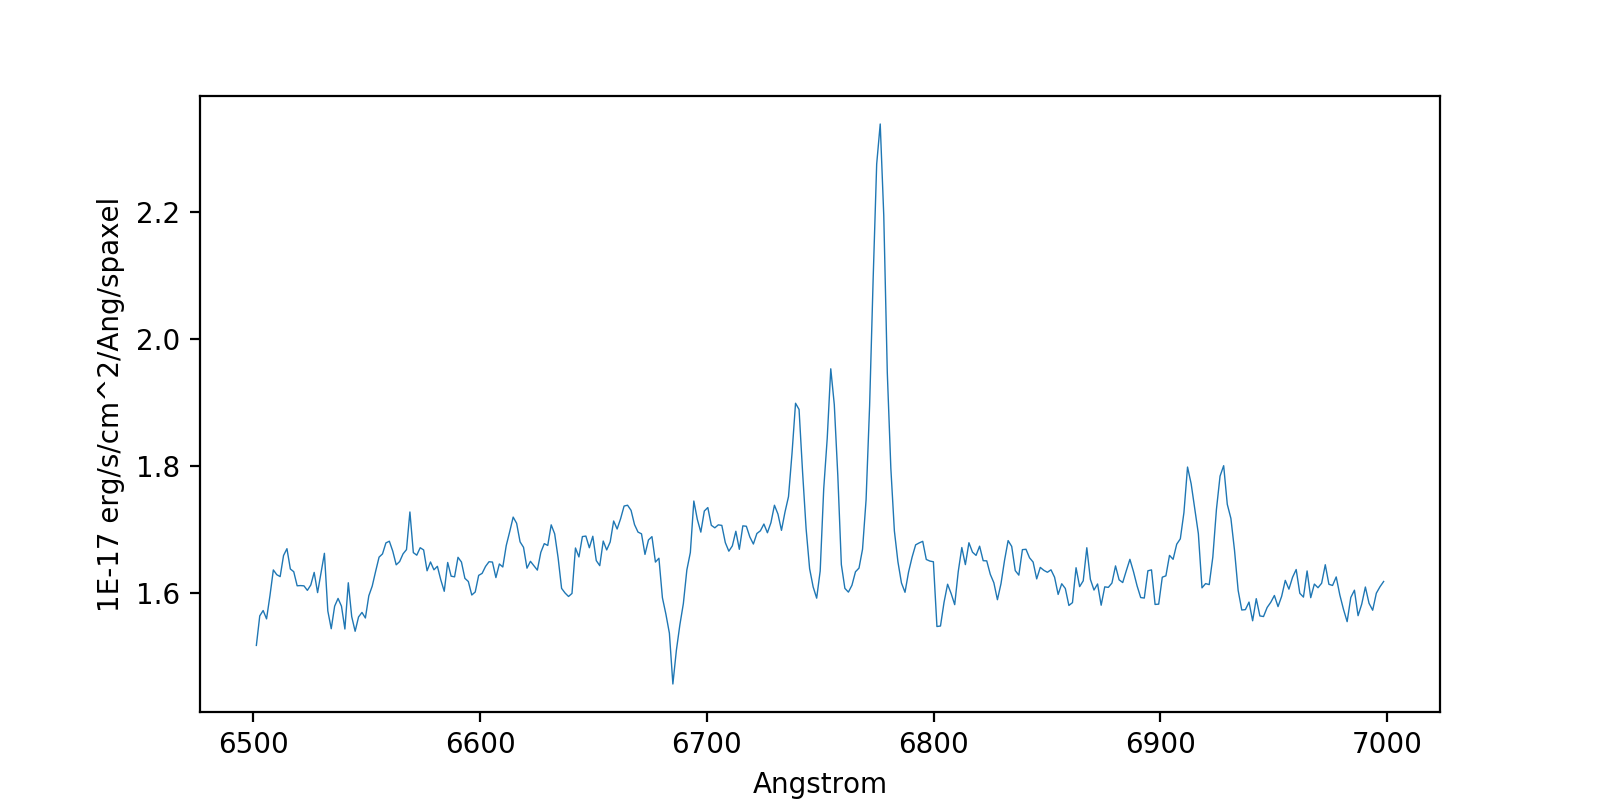

Text(0, 0.5, '1E-17 erg/s/cm^2/Ang/spaxel')

In [4]:
pl.figure()
pl.gcf().set_size_inches((8.,4.))
pl.plot(spectrum.spectral_axis, spectrum.flux, linewidth=0.5, label='obs')
pl.xlabel(str(spectrum.spectral_axis.unit))
pl.ylabel(str(spectrum.flux.unit))

## Read model data

The UI is assumed to feed an instance of an astropy compound model to the backed API.  

In [5]:
g1 = models.Gaussian1D(amplitude=0.7*funit, mean=6776.*wunit, stddev=3*wunit)
g2 = models.Gaussian1D(amplitude=0.5*funit, mean=6755.*wunit, stddev=3*wunit)
g3 = models.Gaussian1D(amplitude=0.4*funit, mean=6740.*wunit, stddev=3*wunit)
continuum = models.Const1D(amplitude=1.5*funit)

model_init = g1 + g2 + g3 + continuum

In [6]:
fitted_model = fit_lines(spectrum, model_init, window=(6720*wunit, 6800*wunit))

In [7]:
fitted_values = fitted_model(spectrum.spectral_axis)

### Check result

In [8]:
fitted_model

<CompoundModel(amplitude_0=0.68488189 1E-17 erg/s/cm^2/Ang/spaxel, mean_0=6775.95115154 Angstrom, stddev_0=2.835011 Angstrom, amplitude_1=0.30217777 1E-17 erg/s/cm^2/Ang/spaxel, mean_1=6754.8446233 Angstrom, stddev_1=1.98789746 Angstrom, amplitude_2=0.24347568 1E-17 erg/s/cm^2/Ang/spaxel, mean_2=6739.32141713 Angstrom, stddev_2=2.56705518 Angstrom, amplitude_3=1.65496775 1E-17 erg/s/cm^2/Ang/spaxel)>

<IPython.core.display.Javascript object>


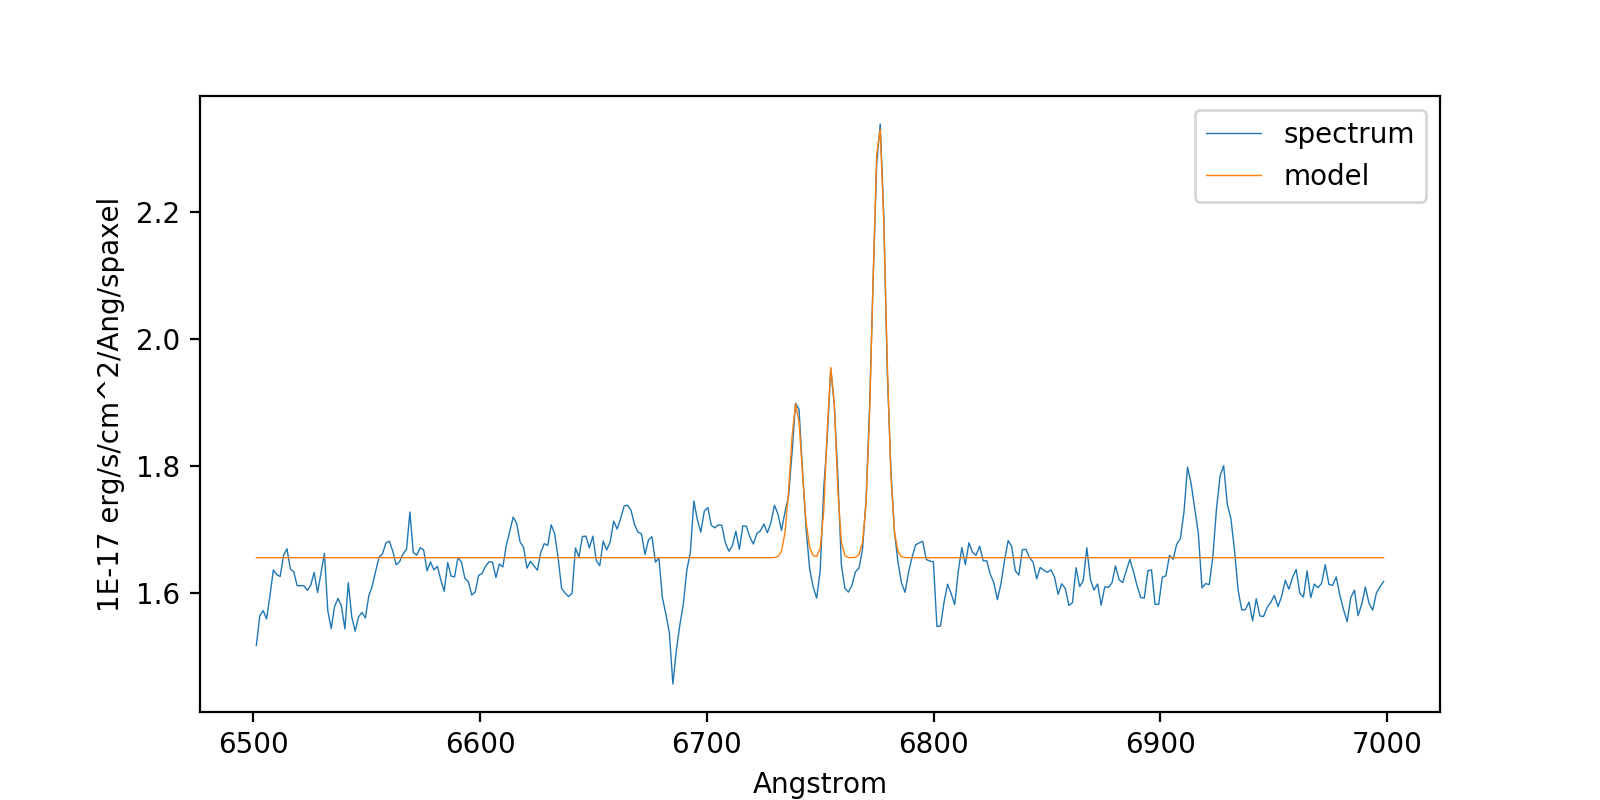

Text(0, 0.5, '1E-17 erg/s/cm^2/Ang/spaxel')

In [11]:
pl.figure()
pl.gcf().set_size_inches((8.,4.))
pl.plot(spectrum.spectral_axis, spectrum.flux, linewidth=0.5, label='spectrum')
pl.plot(spectrum.spectral_axis, fitted_values, linewidth=0.5, label='model')
pl.legend()
pl.xlabel(str(spectrum.spectral_axis.unit))
pl.ylabel(str(spectrum.flux.unit))